In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import isnan
from patch_based_se import PSE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torchvision import datasets, transforms

seed = torch.random.seed()
torch.manual_seed(seed)

In [31]:
transform = transforms.Compose([
                                transforms.CenterCrop((256,256)),
                                transforms.RandomHorizontalFlip(0.2),
                                transforms.RandomVerticalFlip(0.2),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                ])

target_transform = transforms.Compose([
                                       transforms.CenterCrop((256,256)),
                                       transforms.RandomHorizontalFlip(0.2),
                                       transforms.RandomVerticalFlip(0.2),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                         ])
train_set = datasets.VOCSegmentation(year='2007', image_set='trainval', root='../datasets', download=False,
                                     transform=transform, target_transform=transform)
test_set = datasets.VOCSegmentation(year='2007', image_set='test', root='../datasets', download=False,
                                    transform=transform, target_transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False,drop_last=True)

In [32]:
a = next(iter(train_loader))
imgs,labels = a
print(imgs.shape)
print(labels.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


In [33]:
class SElayer(nn.Module):
    def __init__(self, in_features, reduction=16):
        super(SElayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linears = nn.Sequential(
            nn.Linear(in_features, in_features//reduction,bias=False),
            nn.ReLU(inplace=True),

            nn.Linear(in_features//reduction, in_features, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, h, w = x.size()
        weights = self.avg_pool(x).view(b, c)
        weights = self.linears(weights).reshape(b, c, 1, 1)
        return x * weights.expand_as(x)

In [34]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, middle_channels=None):
        super(DoubleConv, self).__init__()
        if middle_channels is None:
            middle_channels = out_channels
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, middle_channels=None):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, middle_channels),
        )

    def forward(self, x):
        return self.down(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, middle_channels=None):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.pse = PSE(in_channels,4,16)
        self.conv = DoubleConv(in_channels, out_channels, middle_channels)
        self.dropout = nn.Dropout2d(p=0.2)

    def forward(self, x1, x2):
        #x1是下采的，x2是本层的
        x1 = self.pse(x1)
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        out = torch.cat([x2, x1], dim=1)
        out = self.dropout(out)
        return self.conv(out)


class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Out, self).__init__()
        self.out = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),

                )

    def forward(self, x):
        return self.out(x)

In [35]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels,middle_channels=None):
        super(UNet,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.inc = DoubleConv(self.in_channels, 64,middle_channels)
        self.down1 = Down(64, 128,middle_channels)  #256-->128
        self.down2 = Down(128, 256,middle_channels) #128-->64
        self.down3 = Down(256, 512,middle_channels)  #64-->32
        self.down4 = Down(512, 1024,middle_channels) #32-->16
        self.up1 = Up(1024, 512,middle_channels)
        self.up2 = Up(512, 256, middle_channels)
        self.up3 = Up(256, 128, middle_channels)
        self.up4 = Up(128, 64, middle_channels)
        self.out = Out(64, self.out_channels)


    def forward(self, x):
        x0 = self.inc(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        x = self.up1(x4,x3)
        x = self.up2(x,x2)
        x = self.up3(x,x1)
        x = self.up4(x,x0)
        return self.out(x)

model = UNet(3,21)
model.to(device)

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)


def compute_iou(pred, target, num_classes):
    """
    计算每个类别的IoU（交并比）

    参数：
    - pred: 预测标签，形状为 (N, H, W)
    - target: 真实标签，形状为 (N, H, W)
    - num_classes: 类别总数（包括背景类）

    返回：
    - iou_list: 每个类别的IoU列表
    """
    iou_list = []
    for i in range(num_classes):
        # 计算每个类别的交集和并集
        intersection = ((pred == i) & (target == i)).sum().float()  # 类别i的交集
        union = ((pred == i) | (target == i)).sum().float()  # 类别i的并集

        if union == 0:
            iou = float('nan')  # 如果类别i在预测和真实标签中都没有出现，IoU为NaN
        else:
            iou = intersection / union  # 计算IoU

        iou_list.append(iou)

    return iou_list

def mean_iou(pred, target, num_classes):
    """
    计算所有类别的平均IoU（mIoU）

    参数：
    - pred: 预测标签，形状为 (N, H, W)，C是类别数
    - target: 真实标签，形状为 (N, 1, H, W)
    - num_classes: 类别总数（包括背景类）

    返回：
    - mIoU: 所有类别的平均IoU
    """

    target = target.squeeze(1)  # 去除通道维度，得到形状 (N, H, W)

    # 计算每个类别的IoU
    iou_list = compute_iou(pred, target, num_classes)

    valid_iou = torch.tensor([iou for iou in iou_list if not isnan(iou)])
    # 计算有效类别的平均IoU
    mIoU = valid_iou.clone().mean().item()  # 计算所有有效IoU的平均值
    return mIoU

def train(num_epochs):
    model.train()
    losses = []
    ious = []
    epoches = torch.arange(1, num_epochs + 1)

    for epoch in range(num_epochs):
        running_loss = 0.0
        all_pred = []
        all_target = []
        for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device).squeeze(1).long()
            y_pred = model(x)
            #print(y_pred.shape,y.shape)
            loss = criterion(y_pred, y)
            #print(f"loss: {loss}")
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().cpu().item()

            # 收集所有预测值和目标值
            all_pred.append(y_pred.argmax(dim=1).cpu())  # 获取最大概率的类别索引
            all_target.append(y.cpu())  # 获取真实标签
            if (idx + 1) % 10 == 0:
                print(
                    f"Epoch [{epoch +1}/{num_epochs}],Batches[{idx + 1}/{len(train_loader)}], Loss: {running_loss / ((idx + 1) ):.3f} , ")

        all_pred = torch.cat(all_pred, dim=0)

        all_target = torch.cat(all_target, dim=0)

        mIou = mean_iou(all_pred,all_target,20)


        ious.append(mIou)

        losses.append(running_loss / len(train_loader.dataset))

        print(f"第{epoch + 1}轮的训练精度为：{(100*mIou):.2f}%\n")
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(epoches, losses)
    ax[0].set_title('LOSS')
    ax[1].plot(epoches, ious)
    ax[1].set_title('IoU')


def test():
    model.eval()  # 设置模型为评估模式
    all_pred = []
    all_target = []

    with torch.no_grad():  # 不计算梯度
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).squeeze(1).long()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
            all_pred.append(predicted.cpu())
            all_target.append(labels.cpu())
        all_pred = torch.cat(all_pred, dim=0)
        all_target = torch.cat(all_target, dim=0)
        mIoU = mean_iou(all_pred,all_target,21)
        print(f"测试集精度{100*mIoU:.2f}%\n")

Epoch [1/50],Batches[10/52], Loss: 0.229 , 
Epoch [1/50],Batches[20/52], Loss: 0.225 , 
Epoch [1/50],Batches[30/52], Loss: 0.225 , 
Epoch [1/50],Batches[40/52], Loss: 0.229 , 
Epoch [1/50],Batches[50/52], Loss: 0.231 , 
第1轮的训练精度为：46.84%

Epoch [2/50],Batches[10/52], Loss: 0.217 , 
Epoch [2/50],Batches[20/52], Loss: 0.231 , 
Epoch [2/50],Batches[30/52], Loss: 0.236 , 
Epoch [2/50],Batches[40/52], Loss: 0.235 , 
Epoch [2/50],Batches[50/52], Loss: 0.232 , 
第2轮的训练精度为：46.83%

Epoch [3/50],Batches[10/52], Loss: 0.246 , 
Epoch [3/50],Batches[20/52], Loss: 0.238 , 
Epoch [3/50],Batches[30/52], Loss: 0.236 , 
Epoch [3/50],Batches[40/52], Loss: 0.229 , 
Epoch [3/50],Batches[50/52], Loss: 0.232 , 
第3轮的训练精度为：46.85%

Epoch [4/50],Batches[10/52], Loss: 0.272 , 
Epoch [4/50],Batches[20/52], Loss: 0.245 , 
Epoch [4/50],Batches[30/52], Loss: 0.240 , 
Epoch [4/50],Batches[40/52], Loss: 0.238 , 
Epoch [4/50],Batches[50/52], Loss: 0.231 , 
第4轮的训练精度为：46.84%

Epoch [5/50],Batches[10/52], Loss: 0.230 , 
Epoc

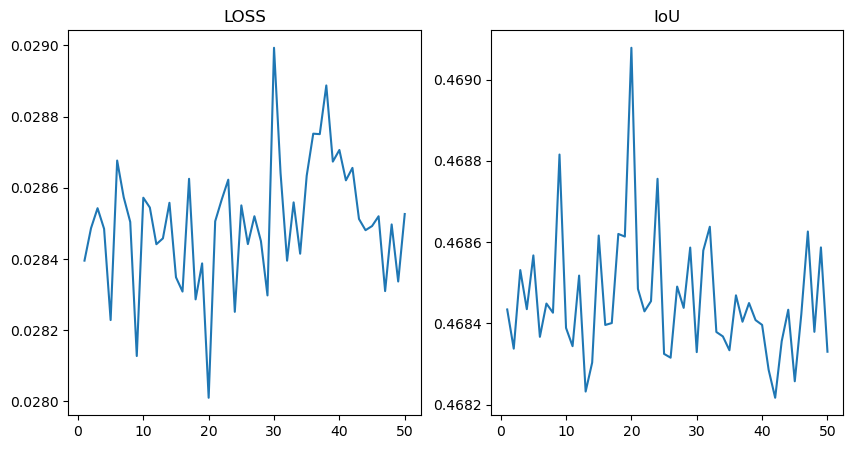

In [42]:
if __name__ == '__main__':
    model.load_state_dict(torch.load('pse_model.pth_4',weights_only=True),strict=False)
    train(50)
    test()


In [41]:
torch.save(model.state_dict(), 'pse_model.pth_4')